<a href="https://colab.research.google.com/github/NovaDileep/mainproject/blob/main/facialKeypointDetection_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# RUN THIS ONLY IF YOU ARE IN GOOGLE COLAB NOTEBOOK
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/MyDrive/Colab Notebooks")
!ls

drive  sample_data
E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 checkpoint1.hdf5		    man.jpg	      Untitled0.ipynb
'Copy of facial_expression.ipynb'   model1.h5	      Untitled1.ipynb
 fa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#####  LOADING AND EXTRACTING DATA   #####


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array

  


# # This snippet is just to check/verify data
# imgs, labels = data_loader()
# print(imgs.shape)
# print(labels.shape)

# n=0
# labels[n] = (labels[n]*48)+48
# image = np.squeeze(imgs[n])
# plt.imshow(image, cmap='gray')
# plt.plot(labels[n][::2], labels[n][1::2], 'ro')
# plt.show()
    

In [5]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model1.h5')




Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Epoch 1/60
27/27 [==============================] - 34s 42ms/step - loss: 0.0561 - accuracy: 0.4300 - val_loss: 0.0124 - val_accuracy: 0.4322

Epoch 00001: val_loss improved from inf to 0.01242, saving model to checkpoint1.hdf5
Epoch 2/60
27/27 [==============================] - 0s 16ms/step - loss: 0.0102 - accuracy: 0.5915 - val_loss: 0.0086 - val_accuracy: 0.4322

Epoch 00002: val_loss improved from 0.01242 to 0.00861, saving model to checkpoint1.hdf5
Epoch 3/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0066 - accuracy: 0.7037 - val_loss: 0.0083 - val_accuracy: 0.4322

Epoch 00003: val_loss improved from 0.00861 to 0.00831, saving model to checkpoint1.hdf5
Epoch 4/60
27/27 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.7174 - val_loss: 0.0076 - val_accuracy: 0.4322

Epoch 00004: val_loss improved from 0.00831 to 0.00764, saving

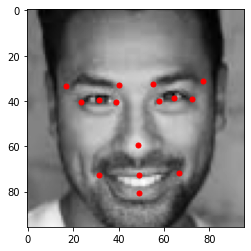

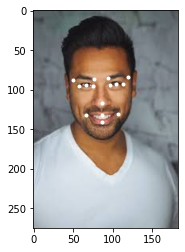

In [7]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####


import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('man.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()




In [ ]:
####  TEST YOUR VIDEO FILE WITH THE MODEL  #####


from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time



model = load_model('model1.h5')  # <-- Saved model path


# input video file path
input_file = 'testVideo.mp4'


# output file path
output_filename = 'testVideo_out.avi'  


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# cap = cv2.VideoCapture(0)


cap = cv2.VideoCapture(input_file)
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_filename, fourcc, 20.0, (width, height))


frame_no = 0
while cap.isOpened():

    a = time.time()
    
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)
            # cv2.line(frame, last_point, tuple(point), (0,0,255), thickness=1)
            # cv2.putText(overlay, str(i), tuple(point), 1, 1, (255, 255, 255))

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)


        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)

        out.write(frame)
        # cv2.imshow('frame',frame)
        b = time.time()
        print(str((b-a)))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
           

cap.release()
cv2.destroyAllWindows()


In [ ]:
'''
For more details watch >> https://www.youtube.com/watch?v=vC3bTziLRTA

'''